# Import libraries

Our data analysis is dependent on the following packages:
- [pandas](https://pandas.pydata.org/) for data manipulation
- [PyEnsembl](https://github.com/openvax/pyensembl) for working with genome data
- [seaborn](https://seaborn.pydata.org/) for drawing attractive statistical graphs
- [Matplotlib](https://matplotlib.org/) for visualizing data relationships
- [methylcheck](https://pypi.org/project/methylcheck/) for the density plot (they do it nice)
- [methylprep](https://pypi.org/project/methylprep/) to use methylcheck
- [umap-learn](https://pypi.org/project/umap-learn/) for building UMAPs
- [scikit-learn](https://scikit-learn.org/stable/index.html) for machine learning


You can install these modules by running the below script inside Jupyter:
```
%pip install pandas
%pip install pyensembl
%pip install seaborn
%pip install methylcheck
%pip install methylprep
%pip install umap-learn
%pip install scikit-learn
```

In [1]:
from pyensembl import EnsemblRelease
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import methylcheck
import pickle
from sklearn.decomposition import PCA
import umap.umap_ as umap

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Open counts file
df = pd.read_pickle('../Data/counts_data.pickle')    

# Open clinical data
clinical_data = pd.read_pickle("../Data/clinical_data.pickle")

# Change Ensembl IDs to HGNC

## Gather meta data of all identified genes

In [6]:
# Reference genome = GRCh38
# 9,033 Ensembl IDs were not identified
# 11,309 Ensembl IDs were identified but have no Gene ID (for the reference genome GRCh38)
    # These 11,309 were included in meta_data.pickle (gene_meta_data dataframe)

# Using pyensembl to get Ensembl Gene IDs
Genome = EnsemblRelease()
gene = Genome.gene_by_id(df.index[0])
gene_meta_data = pd.Series([gene.gene_id, gene.gene_name, gene.biotype, gene.contig, gene.start, gene.end, gene.strand]).to_frame().transpose()

# Getting all the genes in the count file
unnamed_genes = []
for id, ensembl in enumerate(df.index):
    try:

        if id == 0:
            continue
        
        gene = Genome.gene_by_id(ensembl)

        temp_list = pd.Series([gene.gene_id, gene.gene_name, gene.biotype, gene.contig, gene.start, gene.end, gene.strand]).to_frame().transpose()
        gene_meta_data = gene_meta_data.append(temp_list)

    except:
        unnamed_genes.append(ensembl)

# Making it pretty
gene_meta_data = gene_meta_data.rename(columns={0:'Gene_ID', 1:'Gene_Name', 2:'Gene_Biotype', 3:'Contig_Chromosome', 4:'Start', 5:'End', 6:'Strand'})
gene_meta_data = gene_meta_data.set_index("Gene_ID")

## Dropping nameless genes from dataframe

In [7]:
identified_nameless_genes = []

for id, ensembl in enumerate(df.index):
    try:
        gene = Genome.gene_by_id(ensembl)

        if gene.gene_name == "":
            identified_nameless_genes.append(ensembl)
            continue
    except:
        continue

# Dropping the genes that have info about them, but no name (interesting ones)
gene_meta_data2 = gene_meta_data.drop(identified_nameless_genes)

# Gathering only the name of the genes (instead of the metadata (where can we find them, chr, etc.))
gene_names_column = gene_meta_data2["Gene_Name"]

# Dropping unnamed genes
df2 = df.drop(unnamed_genes)

# Finally making the HGNC genes in the index (where Ensembl lied)
df2 = df2.join(gene_names_column.to_frame()).set_index("Gene_Name")

In [23]:
df2

,TARGET-20-PABGKN-09A-01R,TARGET-20-PABHET-03A-02R,TARGET-20-PABHKY-03A-02R,TARGET-20-PABLDZ-04A-01R,TARGET-20-PABLDZ-09A-04R,TARGET-20-PACDZR-09A-02R,TARGET-20-PADDXZ-03A-02R,TARGET-20-PADYIR-04A-01R,TARGET-20-PADYIR-09A-01R,TARGET-20-PADZCG-04A-01R,...,TARGET-20-PAXMKU-09A-01R,TARGET-20-PAXMLI-09A-01R,TARGET-20-PAXMLN-09A-01R,TARGET-20-PAXMLW-09A-01R,TARGET-20-PAXMNG-09A-01R,TARGET-20-PAXMNR-09A-01R,TARGET-20-PAXMPF-09A-01R,TARGET-20-PAXMPG-09A-01R,TARGET-20-PAXMPW-09A-01R,TARGET-20-PAXMRA-09A-01R
Gene_Name,,,,,,,,,,,,,,,,,,,,,
SCYL3,900,2270,1840,482,206,479,512,480,863,594,...,325,444,590,729,546,326,292,1487,528,699
C1orf112,577,1871,3605,75,622,413,937,792,263,141,...,106,805,898,848,815,575,202,1896,932,1238
FGR,11820,486,1547,1286,1032,322,746,4731,14141,11891,...,3458,12354,8893,7641,8057,12196,787,1546,689,13332
CFH,98,18,284,0,166,68,1037,70,24,215,...,12,32,11,634,31,43,21,4535,46,242
STPG1,360,920,446,213,126,250,144,340,223,130,...,124,178,135,164,211,121,39,215,267,216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DUX4L18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DUX4L17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TTTY25P,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Log Scale the data

In [4]:
df2 = np.log2(df + 1)
description_log_scaled_dataset = df2.T.describe().T

# Adjusting for non-expressed genes (37,688 in total)
HGNC_Log_Scaled = df2[description_log_scaled_dataset["std"] > 0]

# Creating a final, cleaned data frame

In [ ]:
# Gather Log-Scaled data
df0 = HGNC_Log_Scaled.T.reset_index()
df1 = df0.join(df0['index'].str.rsplit(pat='-',n=2,expand=True)[0])
df2 = df1.set_index(0)

# Change index of clinical data, then drop duplicates
clinical_data = clinical_data.rename(columns={"TARGET USI":"Patient_ID"}).set_index("Patient_ID")
clinical_data2 = clinical_data.reset_index().drop_duplicates(subset='Patient_ID').set_index('Patient_ID')

# Join Log-Scale and Clinical Data
df3 = df2.join(clinical_data2, how='inner')

df4 = df3.set_index("index")

# Only protocol/cohort we are going to use because it has >1000 samples and cohorts are not batch-corrected
df5 = df4[df4["Protocol"] == "AAML1031"]

# Get clinical data from the dataframe
df5_clinical  = df5.iloc[:,df3.shape[1]-clinical_data2.shape[1]-1:]

# Get the data from the dataframe
x = df5.iloc[:,:df3.shape[1]-clinical_data2.shape[1]-2]

# Export

In [ ]:
# Clinical Data
clinical_data.to_pickle("../Data/pickled/clinical_data.pickle")

# Processed Data
x.to_pickle("../Data/pickled/log_scaled_data.pickle")

# Gene meta data (where it lies, which chromosome, what it does, etc)
gene_meta_data.to_pickle('../Data/Pre_Processed/meta_data.pickle')

# Genes with no HGNC
unnamed_genes.to_pickle('../Data/Pre_Processed/unnamed_genes.pickle')

# Plotting

## Load stuff

In [5]:
log_scaled_data = pd.read_pickle('../Data/log_scaled_data.pickle')
clinical = pd.read_pickle('../Data/clinical_data.pickle')

## Density plot

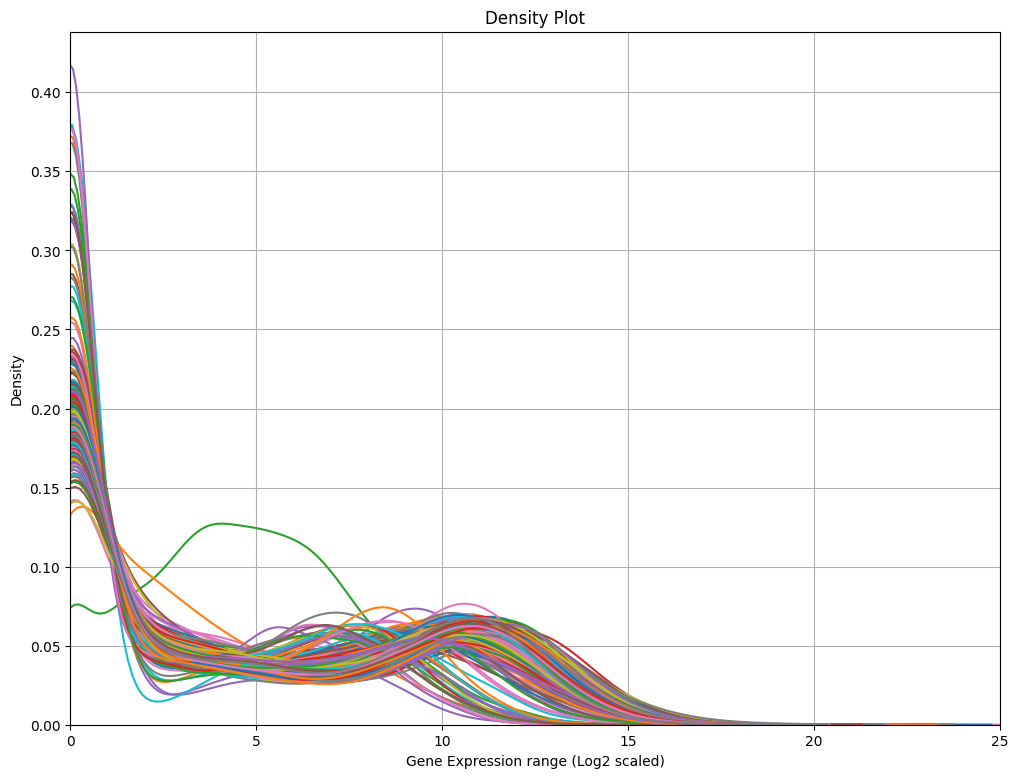

In [4]:
methylcheck.beta_density_plot(log_scaled_data, plot_title="Density Plot")

## PCA

In [6]:
# Fit PCA
pca_decomp = PCA(random_state=42, n_components=2)
data_PCs = pca_decomp.fit_transform(log_scaled_data.T)

In [27]:
def draw_PCAplot(score, hue=None):
    
    sns.set_theme(style="white", color_codes=True)

    # Define variables
    score2 = score[:,0:2]
    xs = score2[:,0]
    ys = score2[:,1]

    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    # Define scatterplot

    sns.scatterplot(x=xs * scalex, y=ys * scaley,
                    palette='husl', s=10,
                    linewidth=0, alpha=1,
                    data=clinical, hue=hue)

    # Define plot specs
    plt.title("PCA Decomposition by RNA-seq, N=1038",
               fontsize = 12)        
               
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.tight_layout()

    # Save figure
    if(hue):
        title = hue
        plt.savefig('../Figures/PCA/PCA_by_' + title + '.png',
        bbox_inches='tight', dpi=300)
    else:
        plt.savefig('../Figures/PCA/PCA.png',
        bbox_inches='tight', dpi=300)
        

    return(plt.show())

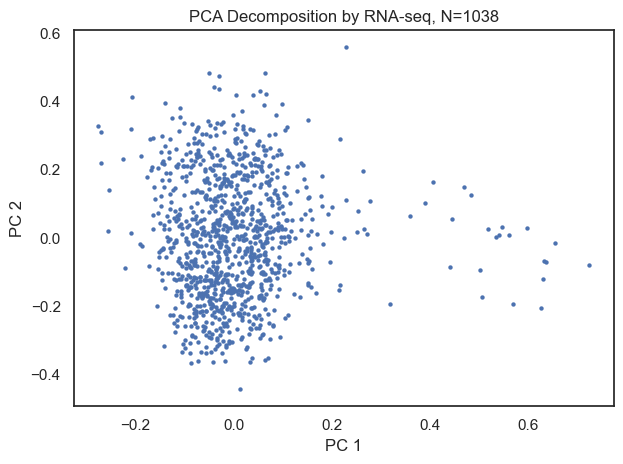

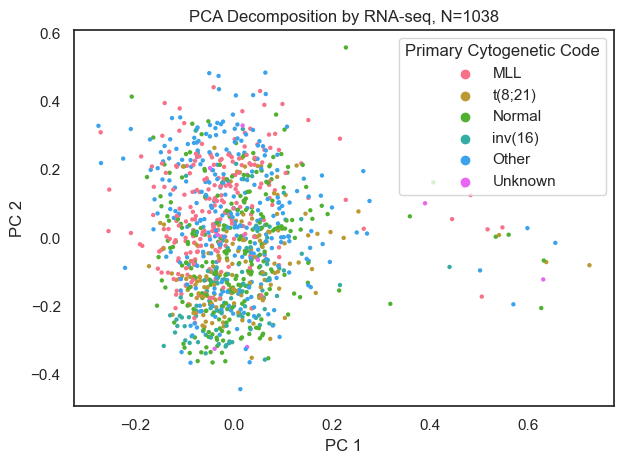

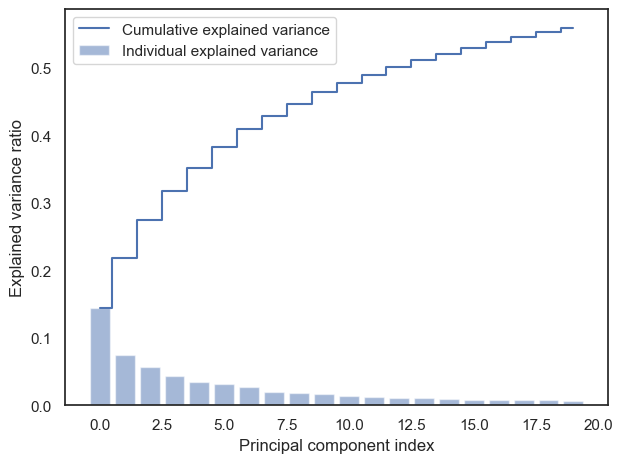

In [29]:
# Draw plots
draw_PCAplot(data_PCs)
draw_PCAplot(data_PCs, hue="Primary Cytogenetic Code")

# Draw explained variance for the first 20 PCs
pca_ev = PCA(random_state=42, n_components=20)
pcs_ev = pca_ev.fit_transform(log_scaled_data.T)
exp_var_pca = pca_ev.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('../Figures/PCA/PCA_Explained_Variance.png',
        bbox_inches='tight', dpi=300)
plt.show()

## UMAP

In [36]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.01, n_epochs=100, random_state=42)
mp_umap = reducer.fit_transform(log_scaled_data.T)

In [39]:
def draw_UMAPplot(score, hue=None):
    
    sns.set_theme(style="white", color_codes=True)

    # Define variables
    score2 = score[:,0:2]
    xs = score2[:,0]
    ys = score2[:,1]

    # Define scatterplot

    sns.scatterplot(data=clinical, x=xs, y=ys,
                    palette='husl', s=10,
                    linewidth=0, alpha=1, hue=hue)

    # Define plot specs
    plt.title("UMAP by RNA-seq, N=1038",
               fontsize = 12)        
               
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.tight_layout()

    # Save figure
    if(hue):
        title = hue
        plt.savefig('../Figures/UMAP/UMAP_by_' + title + '.png',
        bbox_inches='tight', dpi=300)
    else:
        plt.savefig('../Figures/UMAP/UMAP.png',
        bbox_inches='tight', dpi=300)

    return(plt.show())

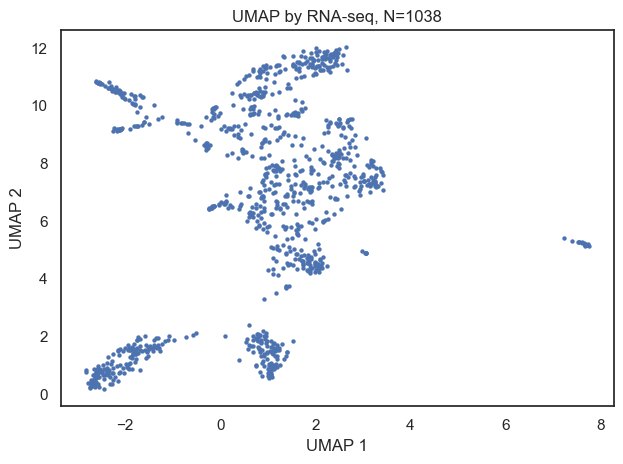

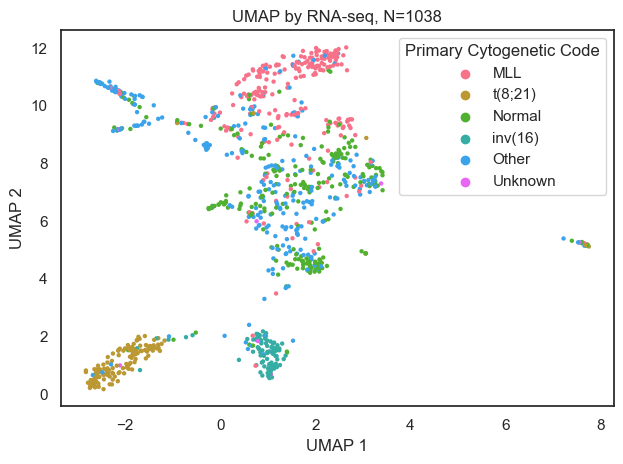

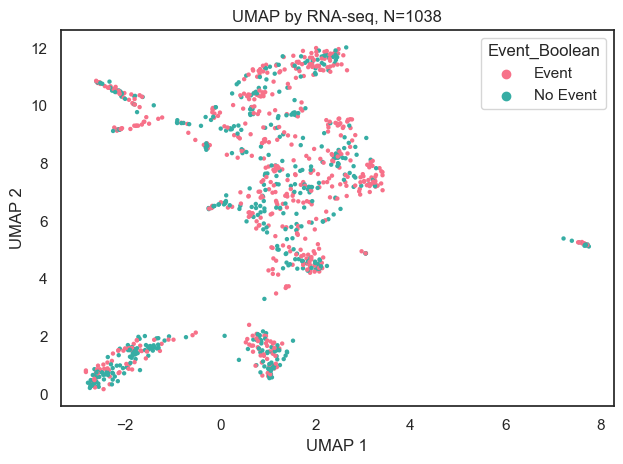

In [40]:
#Call the UMAP function.
draw_UMAPplot(mp_umap)
draw_UMAPplot(mp_umap, hue="Primary Cytogenetic Code")
draw_UMAPplot(mp_umap, hue="Event_Boolean")

## Preparing data for R

In [ ]:
# Read pickled data into data frame
counts = pd.read_pickle('../Data/raw_counts_data.pickle')
# Read data frame into .csv for exporting to R
counts.to_csv('../Data/raw_counts_data.csv', mode ='w+',index_label="Gene")
#Excluding the genes on the .pickle as well - 
counts.to_pickle('../Data/raw_counts_data.pickle')

# Same for clinical data
clinical = pd.read_pickle('../Data/clinical_data.pickle')
clinical.to_csv('../Data/clinical_data.csv')

## Heat Map

In [33]:
coloring = clinical.reset_index()
coloring['index'] = coloring["index"].str.replace('-','.')
coloring = coloring.set_index('index')
lut = dict(zip(coloring["Primary Cytogenetic Code"].unique(), "bgrcmy"))
row_colors = coloring["Primary Cytogenetic Code"].map(lut)

In [38]:
significant_genes = pd.read_csv('../Data/significant_genes.csv').rename(columns={"Unnamed: 0":"Genes"}).set_index("Genes") # From R
significant_genes.T

Genes,CD34,HBG2,HBB,MSLN,MPO,EPX,ZNF521,MEIS1,TRH,HOXA9,HOXA6,XIST,KDM5D,DDX3Y,ZFY,PRKY,USP9Y,RPS4Y1,TXLNGY,UTY
TARGET.20.PAUHFI.09A.01R,8.934838,14.027343,15.331714,6.077467,14.568802,9.617062,15.250474,13.064209,7.650480,14.823156,13.502541,16.613638,5.463604,5.587685,5.162194,5.531011,5.162194,5.162194,5.375517,5.463604
TARGET.20.PAWGYA.09A.01R,11.287837,13.029073,19.182084,5.806407,17.141660,13.862524,8.168202,9.518017,7.847290,8.543284,6.929461,5.844791,13.393360,14.618445,11.006532,10.674442,11.629848,11.913927,11.676193,13.060674
TARGET.20.PAWGYG.09A.01R,9.608613,17.947999,16.132168,6.030848,11.147480,11.779098,9.357103,7.953531,5.699101,6.004032,5.542934,15.904795,5.652787,5.542934,5.542934,5.473366,5.473366,5.699101,5.162194,5.473366
TARGET.20.PAWHCT.09A.01R,13.419216,12.026198,17.315953,5.992836,17.488382,5.702642,11.761317,11.071741,8.643448,12.539548,11.148082,8.366610,13.597017,13.614783,12.033215,11.160315,11.603369,13.292920,11.957405,13.023738
TARGET.20.PAWHFW.09A.01R,10.279700,12.191779,16.001885,6.171586,17.243399,12.792204,6.675548,13.245180,8.611487,8.215058,7.677776,7.677776,13.932268,13.731803,11.067651,11.994066,12.337687,12.539791,12.401478,13.510965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TARGET.20.PAWABG.09A.01R,14.953967,11.892518,18.834936,8.606181,19.091827,12.796755,10.791804,6.726034,14.116340,6.101267,5.463875,16.625954,5.162194,5.162194,5.375709,5.463875,5.162194,5.162194,5.162194,5.162194
TARGET.20.PAWRGZ.09A.01R,8.752837,8.409911,13.001298,5.481086,14.349630,7.717294,12.774498,13.953913,5.995968,13.418566,13.121485,17.053278,5.481086,5.162194,5.162194,5.481086,5.162194,5.162194,5.162194,5.481086
TARGET.20.PAWRGN.03A.01R,12.455084,12.592151,19.399234,5.700890,17.572202,6.913849,12.364575,7.480439,7.979577,10.268250,6.542492,9.250123,5.162194,14.240733,11.875475,12.719481,12.652248,12.466201,5.162194,13.895273
TARGET.20.PAVBEM.09A.01R,12.625012,13.694585,18.583015,12.415014,18.375082,9.873049,6.864287,6.352712,9.708275,5.862319,5.659661,16.713951,5.659661,5.862319,5.162194,5.659661,5.162194,5.717701,5.411850,5.769982


In [51]:
lut

{'MLL': 'b',
 't(8;21)': 'g',
 'Normal': 'r',
 'inv(16)': 'c',
 'Other': 'm',
 'Unknown': 'y'}

In [57]:
# initialize list of lists
data = [['MLL', 'Blue'], ['t(8:21)', 'Green'], ['Normal', 'Red'], ['inv(16)', 'Cyan'], ['Other', 'Magenta'], ['Unknown', 'Yellow']]
  
# Create the pandas DataFrame
df = pd.DataFrame(data, columns=['Primary Cytogenetic Code', 'Color']).set_index("Primary Cytogenetic Code")
df

,Color
Primary Cytogenetic Code,
MLL,Blue
t(8:21),Green
Normal,Red
inv(16),Cyan
Other,Magenta
Unknown,Yellow


c:\Users\sckaffs.fernando\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


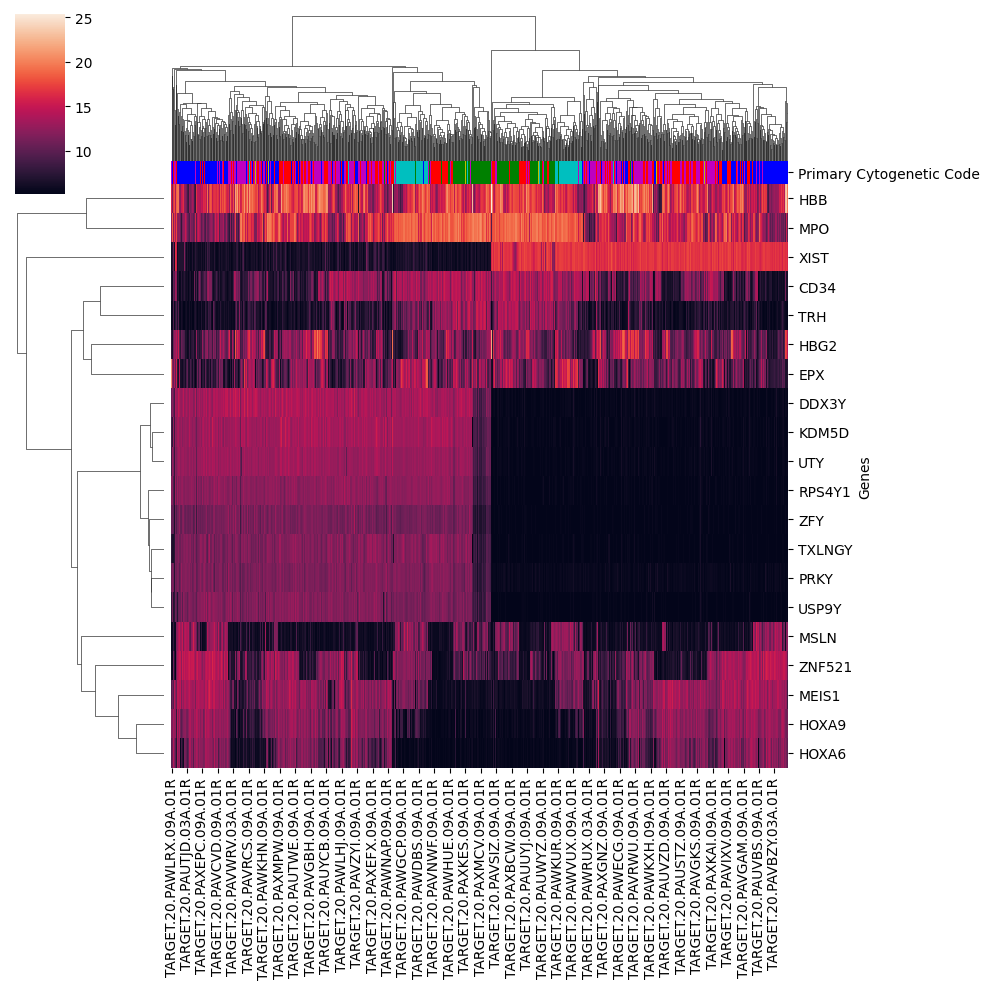

In [53]:
sns.clustermap(significant_genes, col_colors=row_colors)

# Sorting by Primary Cytogenetic Code

In [30]:
raw_counts_data = pd.read_pickle("../Data/counts_data.pickle")

In [31]:
clinical_sorted = clinical.sort_values(by=["Primary Cytogenetic Code"])
overall_sorted = clinical_sorted.join(raw_counts_data.T, how='inner')
clinical_sorted = overall_sorted.iloc[:,:68]
data_sorted = overall_sorted.iloc[:,68:]
data_sorted = data_sorted.T.reset_index()
data_sorted = data_sorted.drop_duplicates(subset=["index"], keep='first')

In [32]:
data_sorted

,index,TARGET-20-PAUHFI-09A-01R,TARGET-20-PAWMAV-09A-01R,TARGET-20-PAVFHT-09A-01R,TARGET-20-PAWMGT-09A-01R,TARGET-20-PAWMHE-09A-01R,TARGET-20-PAWMIP-09A-01R,TARGET-20-PAWMNN-09A-01R,TARGET-20-PAVGAM-09A-01R,TARGET-20-PAWMSW-09A-01R,...,TARGET-20-PAVNYE-09A-01R,TARGET-20-PAWAMF-09A-01R,TARGET-20-PAVAAS-09A-01R,TARGET-20-PAUTIK-09A-01R,TARGET-20-PAVAFJ-09A-01R,TARGET-20-PAUSTM-09A-01R,TARGET-20-PAWWEE-09A-01R,TARGET-20-PAWABG-09A-01R,TARGET-20-PAWWUN-09A-01R,TARGET-20-PAVUEF-09A-01R
0,C1orf112,156,780,611,1449,362,240,811,309,966,...,718,2508,411,434,654,934,1006,2309,903,912
1,FGR,5457,21775,3073,7209,1075,849,11502,6697,2045,...,13644,5967,4107,4175,1645,7367,1702,10734,15837,1804
2,CFH,33,102,21,45,0,6,157,71,92,...,165,11,102,125,6,20,8,251,14,42
3,STPG1,170,141,88,197,431,162,153,90,217,...,62,111,246,112,66,136,186,244,203,121
4,NIPAL3,1580,1342,901,1631,1643,769,2059,936,2182,...,1161,1203,1848,584,372,1566,1471,2604,1962,1220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38102,DUX4L19,0,0,1,1,1,0,0,0,2,...,0,1,0,0,1,0,0,0,0,0
38103,TSPY1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38104,DUX4L18,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38105,DUX4L17,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [33]:
clinical_sorted["Primary Cytogenetic Code"]

TARGET-20-PAUHFI-09A-01R        MLL
TARGET-20-PAWMAV-09A-01R        MLL
TARGET-20-PAVFHT-09A-01R        MLL
TARGET-20-PAWMGT-09A-01R        MLL
TARGET-20-PAWMHE-09A-01R        MLL
                             ...   
TARGET-20-PAUSTM-09A-01R    t(8;21)
TARGET-20-PAWWEE-09A-01R    t(8;21)
TARGET-20-PAWABG-09A-01R    t(8;21)
TARGET-20-PAWWUN-09A-01R    t(8;21)
TARGET-20-PAVUEF-09A-01R    t(8;21)
Name: Primary Cytogenetic Code, Length: 1038, dtype: object

## Export to R

In [34]:
clinical_sorted.to_csv("../Data/clinical_event_sorted.csv")

In [35]:
data_sorted.to_csv("../Data/data_event_sorted.csv", index=False)